<a href="https://colab.research.google.com/github/wallet-maker/spectra/blob/main/notebooks/Spectra_Colaboratory_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This code is now deprecated since Spectra_separated has been moved to the original spectra. This is here for historical reasons. 

In [1]:
%load_ext autoreload
%autoreload 2

# import relevant packages

In [2]:
#import packages
import numpy as np
import json 
import scanpy as sc
from collections import OrderedDict
import scipy 
import pandas as pd
import matplotlib.pyplot as plt


In [3]:
#spectrSpectraports 
import Spectra as spc
from Spectra import Spectra_util as spc_tl
from Spectra import K_est as kst
from Spectra import default_gene_sets

# Load gene_set_dictionary

**load a nested dictionary containing global and cell type specific gene sets in the following format:**

Gene set annotation dictionary with the keys being the celltypes (str) and values being dictionaries with gene set names as keys (str) and gene sets as values (lists of gene names/IDs which matches the gene names/IDs in adata.var_names).

For example:

```
gene_set_dictionary = {'celltype_1':{'gene_set_1':['gene_a', 'gene_b', 'gene_c'], 'gene_set_2':['gene_c','gene_a','gene_e','gene_f']},

'celltype_2':{'gene_set_1':['gene_a', 'gene_b', 'gene_c'], 'gene_set_3':['gene_a', 'gene_e','gene_f','gene_d']},

'celltype_3':{},

'global':"{'gene_set_4':['gene_m','gene_n']} #the global key must be supplied

```

**Note that one key in the dictionary must be 'global' with the corresponding value being a dictionary of gene sets which apply to all cells**

Spectra will use this dictionary to align factors to the input gene sets. Gene sets which apply to only one cell type in the data should be included in the dictionary of that cell type. If a gene sets applies to all cell types in the data, the gene set should be included in the dictionary for 'global'. If a gene set applies to more than one cell type but not all cell types in the data there are two options 1) Include this gene set in each cell type dictionary which will likely result in a separate factor for this gene set in each cell type. OR 2) include this gene set in the 'global' dictionary which will likely result in one factor for this gene set in all cell types. We give additional guidance on the advantages and disadvantages of either approach in the Supplementary Methods of the Spectra paper: https://doi.org/10.1101/2022.12.20.521311

**Load the default dictionary**
We used this dictionary to generate the results in the paper: https://doi.org/10.1101/2022.12.20.521311

In [4]:
# load the default gene set dictionary from the Spectra paper:
annotations = spc.default_gene_sets.load()
annotations["global"]["all_wnt-beta-catenin-signaling"]

['HDAC2',
 'LEF1',
 'CUL1',
 'TP53',
 'GNAI1',
 'DLL1',
 'SKP2',
 'AXIN1',
 'KAT2A',
 'CSNK1E',
 'MAML1',
 'FZD8',
 'NOTCH1',
 'MYC',
 'RBPJ',
 'JAG2',
 'PTCH1',
 'PPARD',
 'HDAC5',
 'AXIN2',
 'NUMB',
 'PSEN2',
 'NKD1',
 'WNT1',
 'TCF7',
 'FRAT1',
 'HDAC11',
 'ADAM17',
 'CCND2',
 'HEY1',
 'NCSTN',
 'JAG1',
 'DVL2',
 'NOTCH4',
 'NCOR2',
 'TPTEP2-CSNK1E',
 'FZD1',
 'CTNNB1',
 'DKK4',
 'HEY2',
 'WNT6',
 'DKK1',
 'WNT5B']

# Custom gene_set_dictionary

**Alternatively you can use Spectra with your custom gene set annotation dictionaries.**

Cytopus Knowledge Base

We supply the Cytopus knowledge base to construct custom input gene set dictionaries for Spectra. For a tutorial visit the github repository: https://github.com/wallet-maker/cytopus

**External Databases**

To obtain optimal results, we recommend using dedicated gene sets, like from the Cytopus database which are tailored to single cell RNA sequencing data (see Supplementary Methods for details https://doi.org/10.1101/2022.12.20.521311).

However, Spectra can also use gene set annotation dictionaries from external databases if they can be provided in the format described above.

# Load adata

In the Spectra paper we use a subsetted, anonymized, log1p-transformed (f(x) = ln(x+1), with x being the raw gene expression counts), and scran-normalized leukocyte single cell RNA sequencing data (https://doi.org/10.1101/2022.12.20.521311). While we recommend scran for leukocyte data, the method with log1p-transformed median library size normalized RNA sequencing data.

In [5]:
# define data paths
obs_key = 'cell_type_annotations' #indicat the column name for the dataframe in adata.obs where to find the cell type lab

In [6]:
# load adata
adata = spc.sample_data.load()
adata

Loaded sample data: (1000, 6397)


AnnData object with n_obs × n_vars = 1000 × 6397
    obs: 'cell_type_annotations'
    var: 'n_cells_by_counts', 'highly_variable'
    uns: 'annotation_SPADE_1_colors', 'cell_type_annotations_colors', 'diffmap_evals', 'draw_graph', 'hvg', 'neighbors', 'pca'
    obsm: 'X_diffmap', 'X_draw_graph_fa', 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [7]:
# alternatively indicate where to find the AnnData object (and uncomment below)
adata_path = '/data/peer/rsaha/supervised-spectra/src/Spectra/data/sample_data.h5ad'
# adata = sc.read_h5ad(adata_path)

**Important: The cell type labels have to match with the cell type labels in the gene set dictionary**

In [8]:
# cell type labels in adata
list(set(adata.obs[obs_key]))

['ILC3',
 'pDC',
 'DC',
 'B_naive',
 'NK',
 'CD8_T',
 'Treg',
 'CD4_T',
 'MDC',
 'gdT',
 'mast',
 'B_memory',
 'plasma',
 'B_GC']

In [9]:
# cell type in gene set annotation dictionary
list(set(annotations.keys()))

['DC',
 'ILC3',
 'pDC',
 'B_naive',
 'NK',
 'CD8_T',
 'Treg',
 'CD4_T',
 'MDC',
 'gdT',
 'mast',
 'global',
 'B_memory',
 'plasma',
 'B_GC']

**if labels do not match adjust the labels either in adata or in annotations**

For example define and map a dictionary mapping the annotations in the adata object to the keys in the gene set annotations dictionary or vice versa. **Note that if you have a cell type in your adata for which you do not have any gene sets in your gene set annotation dictionary you must include an empty dictionary under that cell type key.** Afterwards confirm that the matching has worked:

In [10]:
#filter gene set annotation dict for genes contained in adata
annotations = spc_tl.check_gene_set_dictionary(
    adata,
    annotations,
    obs_key='cell_type_annotations',
    global_key='global')

Cell type labels in gene set annotation dictionary and AnnData object are identical
Your gene set annotation dictionary is now correctly formatted.


# Fit Spectra model

**General comments**

We start by importing spectra. The easiest way to run spectra is to use the `est_spectra` function in the `spectra` module, as shown below. The default behavior is to set the number of factors equal to the number of gene sets plus one. However, this can be modified by passing an integer e.g. `L = 20` as an argument to the function or a dictionary that maps cell type to an integer per cell type. We provide a method for estimating the number of factors directly from the data by bulk eigenvalue matching analysis, which is detailed further below. 

**Computational comments**

Spectra is memory and cpu intensive.

The here-provided dataset can be run on most computers. For bigger datasets you want to run this in non-interactive mode, as runtime can be 1-2 days for a dataset of ca 200,000 cells with 250 factors and 10 cell types. Run time scales linearly with the number of cell types in your data.

An example hardware you could run a 200,000 cell, 10 cell type, 250 factor dataset on would be:

16 cpus Intel Xeon Gold 256 GB RAM

**Parameters**

`adata` : AnnData object containing cell_type_key with log count data stored in .X

`gene_set_dictionary`:dict or OrderedDict() maps cell types to gene set names to gene sets ; if use_cell_types == False then maps gene set names to gene sets ; must contain "global" key in addition to every unique cell type under .obs.<cell_type_key>

`L`: dict, OrderedDict(), int , NoneType number of factors per cell type ; if use_cell_types == False then int. Else dictionary. If None then match factors to number of gene sets (recommended)

`use_highly_variable` : bool if True, then uses highly_variable_genes

`cell_type_key`: str cell type key, must be under adata.obs.<cell_type_key> . If use_cell_types == False, this is ignored

`use_weights`: bool if True, edge weights are estimated based on graph structure and used throughout training

`lam`: float lambda parameter of the model. weighs relative contribution of graph and expression loss functions

`delta`: float delta parameter of the model. lower bounds possible gene scaling factors so that maximum ratio of gene scalings cannot be too large

`kappa`: float or None if None, estimate background rate of 1s in the graph from data

`rho`: float or None if None, estimate background rate of 0s in the graph from data

`use_cell_types` : bool if True then cell type label is used to fit cell type specific factors. If false then cell types are ignored

`n_top_vals` : int number of top markers to return in markers dataframe

`determinant_penalty` : float determinant penalty of the attention mechanism. If set higher than 0 then sparse solutions of the attention weights and diverse attention weights are encouraged. However, tuning is crucial as setting too high reduces the selection accuracy because convergence to a hard selection occurs early during training [todo: annealing strategy]

`filter_sets` : bool whether to filter the gene sets based on coherence

`label_factors` : bool whether to label the factors by their cell type specificity and their Szymkiewicz–Simpson overlap coefficient with the input marker genes

`overlap_threshold`: float minimum overlap coefficient to assign an input gene set label to a factor

``**kwargs`` : (num_epochs = 10000, lr_schedule = [...], verbose = False) arguments to .train(), maximum number of training epochs, learning rate schedule and whether to print changes in learning rate

**Returns**: SPECTRA_Model object [after training]

**In place**: adds 1. factors, 2. cell scores, 3. vocabulary, and 4. markers as attributes in .obsm, .var, .uns

**default parameters:** 

```
est_spectra(
    adata, 
    gene_set_dictionary, 
    L = None,
    use_highly_variable = True, 
    cell_type_key = None, 
    use_weights = True, 
    lam = 0.01, 
    delta=0.001,
    kappa = None, 
    rho = 0.001, 
    use_cell_types = True, 
    n_top_vals = 50, 
    filter_sets = True, 
    label_factors=True, 
    overlap_threshold= 0.2, 
    **kwargs)
```

**fit model with cell type annotations**

Running Spectra with the cell type annotations will give you both global and cell type specific factors.

In [ ]:
# fit the model (We will run this with only 2 epochs to decrease runtime in this tutorial)
model = spc.est_spectra(adata=adata, 
    gene_set_dictionary=annotations, 
    use_highly_variable=True,
    cell_type_key="cell_type_annotations", 
    use_weights=True,
    lam=0.1, # varies depending on data and gene sets, try between 0.5 and 0.001
    delta=0.001, 
    kappa=None,
    rho=0.001, 
    use_cell_types=True,
    n_top_vals=50,
    label_factors=True, 
    overlap_threshold=0.2,
    clean_gs = True, 
    min_gs_num = 3,
    num_epochs=2 #here running only 2 epochs for time reasons, we recommend 10,000 epochs for most datasets
)


In [12]:
#explore eta parameter to detect new factors
model.return_eta_diag()

array([9.37007904e-01, 9.44953918e-01, 9.24962282e-01, 8.86251569e-01,
       9.41704631e-01, 9.67770875e-01, 8.32899928e-01, 9.16679442e-01,
       6.95826113e-01, 8.14303041e-01, 6.43222809e-01, 8.06679904e-01,
       6.52236879e-01, 9.24979925e-01, 9.39530134e-01, 3.80205244e-01,
       9.44590390e-01, 3.86200964e-01, 9.26012278e-01, 9.43459094e-01,
       8.40736628e-01, 8.79024923e-01, 9.26722229e-01, 8.61614048e-01,
       7.70125508e-01, 7.83839643e-01, 7.97663450e-01, 8.54618967e-01,
       9.62037146e-01, 9.26664889e-01, 9.26142097e-01, 7.03201413e-01,
       6.97532952e-01, 7.35826015e-01, 5.09788275e-01, 8.40206504e-01,
       9.51078773e-01, 8.88246894e-01, 9.58381712e-01, 7.89692521e-01,
       7.62339056e-01, 8.09123099e-01, 8.41076255e-01, 9.38234866e-01,
       9.68936026e-01, 7.22776055e-01, 9.23871160e-01, 7.13910103e-01,
       9.39951658e-01, 8.53972852e-01, 9.13529515e-01, 8.97216260e-01,
       9.32295024e-01, 9.66339529e-01, 9.32526767e-01, 5.07659554e-01,
      

## Accessing quantities stored in AnnData

This function stores four important quantities in the AnnData, in addition to returning a fitted model object. *Factors* are the scores that tell you how much each gene contributes to each factor:

In [13]:
#find the factors under adata.uns['SPECTRA_factors'] 
adata.uns['SPECTRA_factors']

array([[4.66898248e-13, 7.64546415e-13, 1.99021277e-13, ...,
        2.42327888e-13, 1.19761060e-14, 2.04832390e-12],
       [5.91858034e-14, 1.16162950e-13, 2.18986463e-13, ...,
        8.90763550e-15, 1.85180328e-13, 1.55762817e-13],
       [2.54673122e-13, 4.91930817e-13, 1.60218899e-12, ...,
        4.77349169e-15, 1.24999888e-14, 1.27726832e-13],
       ...,
       [3.62000232e-13, 2.33659427e-12, 2.97006623e-14, ...,
        9.56398964e-13, 7.13390604e-13, 4.05979471e-14],
       [8.67918084e-02, 1.21608099e-01, 9.99631653e-03, ...,
        8.25946859e-02, 6.02071408e-02, 1.89383043e-02],
       [5.95630771e-02, 6.38280513e-02, 5.04498818e-02, ...,
        6.92885585e-02, 2.05848665e-02, 2.96057644e-02]])

In [14]:
#so you can construct a dataframe for the factor gene weights

#include cell type specificity as a prefix into the index
index_labels = adata.uns['SPECTRA_overlap'].index
gene_weights = pd.DataFrame(adata.uns['SPECTRA_factors'], 
                            index= index_labels,
                            columns=adata.var[adata.var['spectra_vocab']].index)
gene_weights

,KCNC3,NDUFS3,HACD1,FAM214A,TBCD,AC124312.1,PLAGL2,CD40LG,AC022182.1,USP53,...,CCL3L1,BAG3,CDC42EP3,TRAM1,RANBP1,FDFT1,HACD4,FCGR3A,AZGP1,SLC35A1
0-X-global-X-all_biotin_metabolism,4.668982e-13,7.645464e-13,1.990213e-13,1.974057e-14,2.708746e-12,1.522589e-14,1.351938e-14,1.569579e-14,1.296345e-12,1.348339e-13,...,3.661868e-14,8.599155e-15,2.189275e-14,1.066587e-14,1.738532e-13,3.339527e-14,1.064576e-13,2.423279e-13,1.197611e-14,2.048324e-12
1-X-global-X-all_purine_synthesis,5.918580e-14,1.161629e-13,2.189865e-13,4.866622e-14,4.213792e-12,3.180637e-15,1.045135e-14,6.295001e-14,3.213621e-13,3.534873e-14,...,2.285018e-14,1.508205e-15,6.206733e-15,2.560900e-14,4.697577e-12,1.331861e-13,1.420539e-12,8.907635e-15,1.851803e-13,1.557628e-13
2-X-global-X-all_ethanol_metabolism,2.546731e-13,4.919308e-13,1.602189e-12,1.689644e-14,1.858034e-12,1.599603e-14,3.348192e-14,9.677017e-15,1.962305e-13,2.452428e-14,...,2.063928e-14,1.401916e-15,3.603608e-15,7.538957e-14,4.539501e-13,2.196048e-13,1.927529e-12,4.773492e-15,1.249999e-14,1.277268e-13
3-X-global-X-all_amino-sugar-nucleotide-sugar_metabolism,6.042758e-13,8.669707e-14,1.177933e-12,2.361574e-13,5.240887e-13,2.056765e-14,6.930956e-14,3.781215e-14,3.810203e-13,1.068631e-14,...,3.145136e-13,2.571438e-14,7.995761e-15,1.550810e-14,5.976436e-13,5.870081e-14,4.705250e-14,1.661777e-14,2.606205e-14,5.638336e-13
4-X-global-X-all_steroid_metabolism,3.886057e-13,5.747547e-13,1.467625e-13,5.172643e-14,2.608814e-12,8.204031e-15,2.272121e-14,7.492639e-15,4.196127e-13,1.395269e-14,...,3.368321e-14,2.878024e-14,1.367966e-14,1.025574e-14,3.028577e-13,1.192336e-03,2.157426e-12,1.654730e-14,3.963966e-14,2.525538e-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191-X-mast-X-mast_granule-exocytosis,3.711367e-13,1.494758e-12,5.319710e-12,1.824667e-13,3.375565e-12,9.378193e-13,1.366005e-12,3.032167e-13,3.824286e-13,1.444581e-12,...,5.272311e-13,2.014323e-12,4.209403e-13,1.020537e-13,6.814718e-13,2.320865e-12,9.597647e-13,9.682646e-13,8.749452e-13,2.589607e-12
192-X-mast-X-192,5.451262e-02,3.338597e-02,1.273124e-01,2.205662e-02,1.125502e-01,1.446834e-02,6.820205e-02,2.614869e-02,1.261881e-01,6.360572e-02,...,2.219191e-02,2.423704e-02,1.505513e-02,1.729933e-02,1.729692e-02,1.188868e-01,3.398203e-02,1.277836e-01,3.544685e-02,1.437923e-01
193-X-pDC-X-p-DC_CpG-TLR9_response,3.620002e-13,2.336594e-12,2.970066e-14,2.735589e-13,1.603100e-13,1.840264e-12,3.586203e-13,3.117460e-13,7.339760e-13,1.337853e-13,...,2.842804e-13,7.578871e-14,2.046036e-12,2.594708e-12,2.844099e-13,7.584999e-13,1.867068e-12,9.563990e-13,7.133906e-13,4.059795e-14
194-X-pDC-X-194,8.679181e-02,1.216081e-01,9.996317e-03,3.539783e-02,1.833101e-02,4.328771e-02,5.870886e-03,1.457544e-02,1.846855e-02,5.525831e-02,...,1.562760e-02,7.449785e-02,5.352879e-02,5.838779e-02,3.598818e-02,4.208012e-02,1.220466e-01,8.259469e-02,6.020714e-02,1.893830e-02


*Markers* is an array of genes with top scores for every factor:

In [15]:
#find an array of the marker genes per factor here:
adata.uns['SPECTRA_markers']

array([['BTD', 'HLCS', 'SLC5A6', ..., 'TM4SF1', 'PLCD4', 'PSMA3'],
       ['AK2', 'NT5E', 'GMPR', ..., 'JAM3', 'HEXIM1', 'TRIAP1'],
       ['ALDH3B2', 'ALDH3A1', 'ADH1C', ..., 'FUS', 'GNL3', 'EPHA2'],
       ...,
       ['RNF145', 'TCF7', 'HMGB2', ..., 'RETN', 'ALDH9A1', 'ID1'],
       ['NRXN3', 'TLR6', 'CHMP6', ..., 'AIFM3', 'SPRY4', 'LINC02195'],
       ['MIAT', 'APOC3', 'FKBP11', ..., 'PXN', 'MZB1', 'GIT1']],
      dtype=object)

We also provide an approach to label the factors by their Szymkiewicz–Simpson overlap coefficient with the input gene sets. Each factors receives the label of the input gene set with the highest overlap coefficient, given that it the overlap coefficient is greater than the threshold defined in 'overlap_threshold'. Ties in the overlap coefficient by gene set size, selecting the label of the bigger gene set (because smaller gene sets might get bigger overlap coefficients by chance).

We provide a pandas.DataFrame indicating the overlap coefficients for each input gene set with each factor's marker genes. The index of this dataframe contains the *index* of each factor, *assigned label* as well as the *cell type specificity* for each factor in the format:

`['index' + '-X-' + 'cell type specificity' + '-X-' + 'assigned label', ...]`

We use `'-X-'` as a unique seperator to make string splitting and retrieval of the different components of the index easier.

In [16]:
adata.uns['SPECTRA_overlap']

,B_Breg_UP,B_effector-2_UP,B_effector-1_UP,B_IgM-ligation_response,CD4-T_IL12_response,TNK_IL2_response,CD4-T_TH22_UP,CD4-T_TH17_UP,TNK_IL2-STAT5-signaling,T_IL21_response,...,all_thiamin_metabolism,all_NOTCH_signaling,all_galactose_metabolism,all_MYC_targets,all_GLU_metabolism,all_fatty-acid_synthesis,all_glycolysis,all_glutathione_metabolism,all_IL6-JAK-STAT3_signaling,all_autophagy-chaperone-mediated
0-X-global-X-all_biotin_metabolism,0.0,0.0,0.000,0.00,0.0,0.000000,0.0,0.0,0.00,0.0,...,0.00,0.000000,0.000000,0.04,0.027027,0.041667,0.041667,0.0,0.00,0.000000
1-X-global-X-all_purine_synthesis,0.0,0.0,0.000,0.00,0.0,0.000000,0.0,0.0,0.04,0.0,...,0.00,0.000000,0.055556,0.04,0.000000,0.000000,0.000000,0.0,0.00,0.066667
2-X-global-X-all_ethanol_metabolism,0.0,0.0,0.000,0.00,0.0,0.000000,0.0,0.0,0.02,0.0,...,0.00,0.000000,0.000000,0.04,0.000000,0.000000,0.000000,0.0,0.02,0.000000
3-X-global-X-all_amino-sugar-nucleotide-sugar_metabolism,0.0,0.0,0.000,0.00,0.0,0.055556,0.0,0.0,0.00,0.0,...,0.25,0.000000,0.055556,0.04,0.000000,0.000000,0.041667,0.0,0.00,0.000000
4-X-global-X-all_steroid_metabolism,0.0,0.0,0.000,0.00,0.0,0.000000,0.0,0.0,0.00,0.0,...,0.00,0.000000,0.000000,0.00,0.000000,0.125000,0.000000,0.0,0.00,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191-X-mast-X-mast_granule-exocytosis,0.0,0.0,0.000,0.04,0.0,0.000000,0.0,0.0,0.02,0.0,...,0.00,0.029412,0.000000,0.02,0.000000,0.000000,0.041667,0.0,0.00,0.000000
192-X-mast-X-192,0.0,0.0,0.000,0.00,0.0,0.000000,0.0,0.0,0.00,0.0,...,0.00,0.029412,0.000000,0.02,0.000000,0.000000,0.000000,0.0,0.04,0.066667
193-X-pDC-X-p-DC_CpG-TLR9_response,0.0,0.0,0.125,0.02,0.0,0.000000,0.0,0.0,0.02,0.0,...,0.00,0.000000,0.000000,0.06,0.027027,0.041667,0.000000,0.0,0.00,0.000000
194-X-pDC-X-194,0.0,0.0,0.000,0.06,0.0,0.055556,0.0,0.0,0.04,0.0,...,0.00,0.029412,0.000000,0.00,0.000000,0.000000,0.041667,0.0,0.00,0.000000


*Cell scores* are similarly the score of each factor for every cell:

In [51]:
#find an array of cell scores per factor and cell here:
adata.obsm['SPECTRA_cell_scores']

array([[2.43960415e-06, 2.39930131e-06, 4.94279786e-07, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [6.20948738e-05, 3.94966570e-06, 4.67317440e-07, ...,
        0.00000000e+00, 0.00000000e+00, 2.23443986e-01],
       [1.09825994e-05, 1.61300184e-05, 3.83628351e-07, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [9.73832372e-06, 6.67857039e-06, 3.42896684e-07, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.02700689e-05, 4.80575212e-06, 3.87943102e-07, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [6.73142740e-06, 5.71694225e-06, 3.20736967e-07, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

Vocab is a boolean array that is `True` for genes that were used while fitting the model - note that this quantity is only added to the AnnData when `highly_variable` is set to `True`:

In [18]:
#find the vocab here:
adata.var['spectra_vocab']

KCNC3      True
NDUFS3     True
HACD1      True
FAM214A    True
TBCD       True
           ... 
FDFT1      True
HACD4      True
FCGR3A     True
AZGP1      True
SLC35A1    True
Name: spectra_vocab, Length: 6397, dtype: bool

It also includes a dictionary of the factor numbers per cell type:

In [19]:
#find the factor numbere dict here:
adata.uns['SPECTRA_L']

{'B_GC': 1,
 'B_memory': 5,
 'B_naive': 1,
 'CD4_T': 12,
 'CD8_T': 7,
 'DC': 3,
 'ILC3': 1,
 'MDC': 6,
 'NK': 1,
 'Treg': 2,
 'gdT': 1,
 'mast': 2,
 'pDC': 2,
 'plasma': 1,
 'global': 151}

## Acessing model parameters

To access finer grained information about the model fit, we can look at the attributes of the model object directly. Model parameters can be accessed with functions associated with the model object

In [20]:
#this is the model file
dir(model)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'model',
 'use_cell_types']

In [21]:
#e.g. find the lambda parameter the model was trained with:
model.lam

0.1

Apart from cell scores and factors, we can also retrive a number of other parameters this way that are not by default added to the AnnData. Eta diag is the diagonal of the fitted factor-factor interaction matrix; however, its interpretation is that it measures the extent to which each factor is influenced by the prior information. In practice many of these values are zero, indicating that they are estimated without bias introduced by the annotation set. Eta is the full set of factor-factor interaction matrices, whose off diagonals measure the extent to which factors share the same genes. Rho and kappa are parameters that control the background rate of non-edges and edges respectively. These can be fixed throughout training (default) or estimated from the data by providing rho = None or kappa = None to the est_spectra() function or to model.train(). Finally gene scalings are correction factors that normalize each gene based on its mean expression value.

In [22]:
model.return_eta_diag()

array([9.37007904e-01, 9.44953918e-01, 9.24962282e-01, 8.86251569e-01,
       9.41704631e-01, 9.67770875e-01, 8.32899928e-01, 9.16679442e-01,
       6.95826113e-01, 8.14303041e-01, 6.43222809e-01, 8.06679904e-01,
       6.52236879e-01, 9.24979925e-01, 9.39530134e-01, 3.80205244e-01,
       9.44590390e-01, 3.86200964e-01, 9.26012278e-01, 9.43459094e-01,
       8.40736628e-01, 8.79024923e-01, 9.26722229e-01, 8.61614048e-01,
       7.70125508e-01, 7.83839643e-01, 7.97663450e-01, 8.54618967e-01,
       9.62037146e-01, 9.26664889e-01, 9.26142097e-01, 7.03201413e-01,
       6.97532952e-01, 7.35826015e-01, 5.09788275e-01, 8.40206504e-01,
       9.51078773e-01, 8.88246894e-01, 9.58381712e-01, 7.89692521e-01,
       7.62339056e-01, 8.09123099e-01, 8.41076255e-01, 9.38234866e-01,
       9.68936026e-01, 7.22776055e-01, 9.23871160e-01, 7.13910103e-01,
       9.39951658e-01, 8.53972852e-01, 9.13529515e-01, 8.97216260e-01,
       9.32295024e-01, 9.66339529e-01, 9.32526767e-01, 5.07659554e-01,
      

In [23]:
adata.uns['SPECTRA_overlap']

,B_Breg_UP,B_effector-2_UP,B_effector-1_UP,B_IgM-ligation_response,CD4-T_IL12_response,TNK_IL2_response,CD4-T_TH22_UP,CD4-T_TH17_UP,TNK_IL2-STAT5-signaling,T_IL21_response,...,all_thiamin_metabolism,all_NOTCH_signaling,all_galactose_metabolism,all_MYC_targets,all_GLU_metabolism,all_fatty-acid_synthesis,all_glycolysis,all_glutathione_metabolism,all_IL6-JAK-STAT3_signaling,all_autophagy-chaperone-mediated
0-X-global-X-all_biotin_metabolism,0.0,0.0,0.000,0.00,0.0,0.000000,0.0,0.0,0.00,0.0,...,0.00,0.000000,0.000000,0.04,0.027027,0.041667,0.041667,0.0,0.00,0.000000
1-X-global-X-all_purine_synthesis,0.0,0.0,0.000,0.00,0.0,0.000000,0.0,0.0,0.04,0.0,...,0.00,0.000000,0.055556,0.04,0.000000,0.000000,0.000000,0.0,0.00,0.066667
2-X-global-X-all_ethanol_metabolism,0.0,0.0,0.000,0.00,0.0,0.000000,0.0,0.0,0.02,0.0,...,0.00,0.000000,0.000000,0.04,0.000000,0.000000,0.000000,0.0,0.02,0.000000
3-X-global-X-all_amino-sugar-nucleotide-sugar_metabolism,0.0,0.0,0.000,0.00,0.0,0.055556,0.0,0.0,0.00,0.0,...,0.25,0.000000,0.055556,0.04,0.000000,0.000000,0.041667,0.0,0.00,0.000000
4-X-global-X-all_steroid_metabolism,0.0,0.0,0.000,0.00,0.0,0.000000,0.0,0.0,0.00,0.0,...,0.00,0.000000,0.000000,0.00,0.000000,0.125000,0.000000,0.0,0.00,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191-X-mast-X-mast_granule-exocytosis,0.0,0.0,0.000,0.04,0.0,0.000000,0.0,0.0,0.02,0.0,...,0.00,0.029412,0.000000,0.02,0.000000,0.000000,0.041667,0.0,0.00,0.000000
192-X-mast-X-192,0.0,0.0,0.000,0.00,0.0,0.000000,0.0,0.0,0.00,0.0,...,0.00,0.029412,0.000000,0.02,0.000000,0.000000,0.000000,0.0,0.04,0.066667
193-X-pDC-X-p-DC_CpG-TLR9_response,0.0,0.0,0.125,0.02,0.0,0.000000,0.0,0.0,0.02,0.0,...,0.00,0.000000,0.000000,0.06,0.027027,0.041667,0.000000,0.0,0.00,0.000000
194-X-pDC-X-194,0.0,0.0,0.000,0.06,0.0,0.055556,0.0,0.0,0.04,0.0,...,0.00,0.029412,0.000000,0.00,0.000000,0.000000,0.041667,0.0,0.00,0.000000


Examine the parameters of the underlying internal model:

In [24]:
model.internal_model

SpectraCellType(
  (theta): ParameterDict(
      (global): Parameter containing: [torch.FloatTensor of size 6392x151]
      (B_GC): Parameter containing: [torch.FloatTensor of size 6392x1]
      (B_memory): Parameter containing: [torch.FloatTensor of size 6392x5]
      (B_naive): Parameter containing: [torch.FloatTensor of size 6392x1]
      (CD4_T): Parameter containing: [torch.FloatTensor of size 6392x12]
      (CD8_T): Parameter containing: [torch.FloatTensor of size 6392x7]
      (DC): Parameter containing: [torch.FloatTensor of size 6392x3]
      (ILC3): Parameter containing: [torch.FloatTensor of size 6392x1]
      (MDC): Parameter containing: [torch.FloatTensor of size 6392x6]
      (NK): Parameter containing: [torch.FloatTensor of size 6392x1]
      (Treg): Parameter containing: [torch.FloatTensor of size 6392x2]
      (gdT): Parameter containing: [torch.FloatTensor of size 6392x1]
      (mast): Parameter containing: [torch.FloatTensor of size 6392x2]
      (pDC): Parameter con

In [25]:
# #You can save the model like this (this way consumes a lot of storage but does not require the model parameters to load)
# import pickle
# with open('spectra_model.pickle', 'wb') as f:
#     pickle.dump(model, f, pickle.HIGHEST_PROTOCOL)

In [26]:
# #and load it like this:
# with open('spectra_model.pickle', 'rb') as f:
#     model = pickle.load(f)

In [27]:
# #this way needs less storage but requires the original adata, annotations and cell type annotations to load the model again
# model.save('spectra_model_compact')

In [28]:
# #load the model (you will need all the parameters indicated here)
# model = spc.load_from_pickle('spectra_model_compact',adata,gs_dict=annotations,cell_type_key='cell_type_annotations',
#                      )

**fit model without cell type annotations**

You can also fit the model without using the cell type annotations. In this case, instead of a nested gene set annotation dictionary, supply a regular dictionary with gene set names as keys (str) and the gene sets as values (list of gene names/IDs which match the gene names/IDs in the adata.var_names)

In [ ]:
{'global':annotations['global']}

In [ ]:
#fit the model (We will run this with only 2 epochs to decrease runtime in this tutorial)
model_global = spc.est_spectra(adata = adata, gene_set_dictionary = annotations['global'], # because we do not use the cell types
                                                                                    # we will supply a regular dict
                                                                                    # instead of the nested dict above
                        use_highly_variable = True, cell_type_key =None, #"cell_type_annotations" ,
                        use_weights = True, lam = 0.1, 
                        delta=0.001,kappa = 0.00001, rho = 0.00001, 
                        use_cell_types = False, #set to False to not use the cell type annotations
                        n_top_vals = 25, 
                        clean_gs=True,
                        label_factors=True,
                        num_epochs=2 #for demonstration purposes we will only run 2 epochs, we recommend 10,000 epochs
                       )

In [31]:
#show the labeled factors in the data:
adata.uns['SPECTRA_overlap'].index

Index(['0-X-global-X-all_biotin_metabolism',
       '1-X-global-X-all_purine_metabolism',
       '2-X-global-X-all_ethanol_metabolism',
       '3-X-global-X-all_amino-sugar-nucleotide-sugar_metabolism',
       '4-X-global-X-all_steroid_metabolism',
       '5-X-global-X-all_carnitine-shuttle', '6-X-global-X-all_TLR_signaling',
       '7-X-global-X-all_phosphoinositide_signaling',
       '8-X-global-X-all_microautophagy-lysosomal',
       '9-X-global-X-all_TCA-cycle',
       ...
       '141-X-global-X-all_NOTCH_signaling',
       '142-X-global-X-all_galactose_metabolism',
       '143-X-global-X-all_MYC_targets', '144-X-global-X-all_GLU_metabolism',
       '145-X-global-X-all_fatty-acid_synthesis',
       '146-X-global-X-all_glycolysis',
       '147-X-global-X-all_glutathione_metabolism',
       '148-X-global-X-all_IL6-JAK-STAT3_signaling',
       '149-X-global-X-all_autophagy-chaperone-mediated',
       '150-X-global-X-150'],
      dtype='object', length=151)

plotting factor: 80-X-global-X-all_mTORC1_signaling


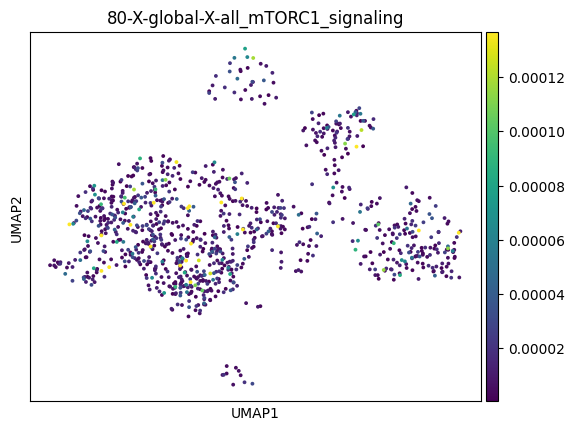

In [32]:
#visualize factor cell scores (this is poorly fitted bc we only ran 2 epochs)
factor_of_interest = adata.uns['SPECTRA_overlap'].index[80]
print('plotting factor:',adata.uns['SPECTRA_overlap'].index[80])

#add cell scores to obs
cell_scores = adata.obsm['SPECTRA_cell_scores'][:,0].astype(float)
adata.obs[factor_of_interest] = cell_scores
sc.pl.umap(adata,color=factor_of_interest,s=30,vmax=np.quantile(cell_scores,0.98))

In [33]:
# #save the adata
# adata_save_path = 'adata_spectra.h5ad'#where to save the adata to
# adata.write(adata_save_path)
# print('Saved adata to:',adata_save_path)

# Accessing the fitted gene-gene graph

One outcome of fitting spectra is to fit a gene-gene graph where edges represent similarities between latent variables associated with each gene (a smoothed version of transcriptional similarity) To access this for say, TNK cells; use the following

In [34]:
soft_graph = model_global.return_graph(ct = "global")
soft_graph

array([[9.3110156e-01, 9.4319582e-02, 2.6325102e-11, ..., 2.2649046e-11,
        2.3441270e-11, 3.5725780e-02],
       [9.4319582e-02, 7.7480978e-01, 2.3126301e-11, ..., 2.0370134e-11,
        2.2176729e-11, 7.1713954e-02],
       [2.6325102e-11, 2.3126301e-11, 2.1073826e-12, ..., 2.1073826e-12,
        2.1073826e-12, 2.7035768e-11],
       ...,
       [2.2649046e-11, 2.0370134e-11, 2.1073826e-12, ..., 2.1073826e-12,
        2.1073826e-12, 2.2608200e-11],
       [2.3441270e-11, 2.2176729e-11, 2.1073826e-12, ..., 2.1073826e-12,
        2.1073826e-12, 2.3714104e-11],
       [3.5725780e-02, 7.1713954e-02, 2.7035768e-11, ..., 2.2608200e-11,
        2.3714104e-11, 8.0346864e-01]], dtype=float32)

for large numbers of genes its clumsy to visualize the whole graph - to visualize a subgraph formed around a particular list of genes, use:

In [35]:
gene_set = list(adata.uns['SPECTRA_markers'][0])
out = spc.graph_network(adata, soft_graph, gene_set)

#this will not show in Google Colaboratory but you can open the file manually outside Google Colaboratory
#out.show("test_graph.html")

In [36]:
adata.uns['SPECTRA_markers'][0].shape

(25,)

this will take N closest genes to your gene set and only visualize this subgraph. The interactive graph file gets saved as an html. To visualize multiple gene sets at the same time, we have a different version of the function that assigns a random color to each gene set:

In [37]:
#gene sets is a list of lists
gene_set_2 = list(adata.uns['SPECTRA_markers'][1])
gene_sets = [gene_set,gene_set_2]
out = spc.graph_network_multiple(adata,soft_graph, gene_sets)
# out.show("test_graph.html")

# Fitting the model without AnnData

Instead of passing an AnnData object to est_spectra one can pass np.ndarray objects directly. The **kwargs contains arguments to the training function, lr_schedule = [1.0,.5,.1,.01,.001,.0001],num_epochs = 10000, verbose = False. To do this, initialize a model:

In [38]:
adata

AnnData object with n_obs × n_vars = 1000 × 6397
    obs: 'cell_type_annotations', '80-X-global-X-all_mTORC1_signaling'
    var: 'n_cells_by_counts', 'highly_variable', 'spectra_vocab'
    uns: 'annotation_SPADE_1_colors', 'cell_type_annotations_colors', 'diffmap_evals', 'draw_graph', 'hvg', 'neighbors', 'pca', 'SPECTRA_factors', 'SPECTRA_markers', 'SPECTRA_L', 'SPECTRA_overlap'
    obsm: 'X_diffmap', 'X_draw_graph_fa', 'X_pca', 'X_tsne', 'X_umap', 'SPECTRA_cell_scores'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [39]:
#define number of factors (only est_spectra has the option to automatically set the factor numbers per celltype)

L = {}
for key in annotations.keys():
    length = len(list(annotations[key].values()))
    L[key] = length + 1
L

{'B_GC': 1,
 'B_memory': 5,
 'B_naive': 1,
 'CD4_T': 12,
 'CD8_T': 7,
 'DC': 3,
 'ILC3': 1,
 'MDC': 6,
 'NK': 1,
 'Treg': 2,
 'gdT': 1,
 'mast': 2,
 'pDC': 2,
 'plasma': 1,
 'global': 151}

In [40]:
#get the genes you want to use (for simplicity we will copy from the adata above)
vocab = list(adata.var_names)

In [41]:
adata.X.todense().shape

(1000, 6397)

In [42]:
len(vocab)

6397

In [43]:
model = spc.SPECTRA_Model(X = adata.X.todense(), L=L, labels = np.array(adata.obs['cell_type_annotations']),  
                          gs_dict = annotations,lam = 0.01, vocab=vocab, use_weights=True,
                          delta=0.001,kappa = None, rho = 0.05,use_cell_types=True)
model.train(X = adata.X.todense(), labels = np.array(adata.obs['cell_type_annotations']),
            num_epochs=2) #we will only do 2 epochs here for demonstration purposes. We recommend 10,000 epochs for most datasets.

100%|██████████| 2/2 [00:05<00:00,  2.79s/it]


It is also required to run the model this way if you want to input arbitrary adjacency matrices instead of a dictionary of gene sets. The gene set dictionary is used to create an adjacency matrix when it is not None.

In [44]:
#you will need the cell type containing model and vocab again --> for this tutorial we will retrain
model = spc.est_spectra(adata = adata, gene_set_dictionary = annotations, 
                        use_highly_variable = True, cell_type_key = "cell_type_annotations", 
                        use_weights = True, lam = 0.1, 
                        delta=0.001,kappa = 0.00001, rho = 0.00001, 
                        use_cell_types = True, n_top_vals = 25, 
                        label_factors = True, #whether to label the factors by their overlap coefficient with the input gene sets
                        overlap_threshold = 0.2, #minimum overlap coefficient that has to be surpassed to assign a label to a factor
                        num_epochs=2 #for demonstration purposes we will only run 2 epochs, we recommend 10,000 epochs
                       )

Cell type labels in gene set annotation dictionary and AnnData object are identical
Your gene set annotation dictionary is now correctly formatted.


100%|██████████| 2/2 [00:05<00:00,  2.71s/it]
/lilac/data/peer/rsaha/supervised-spectra/src/Spectra/Spectra.py:353: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'HLCS' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.iloc[i, j] = id2word[idx_matrix[i, j]]
/lilac/data/peer/rsaha/supervised-spectra/src/Spectra/Spectra.py:353: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'SLC5A6' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.iloc[i, j] = id2word[idx_matrix[i, j]]
/lilac/data/peer/rsaha/supervised-spectra/src/Spectra/Spectra.py:353: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'SLC16A1' has dtype incompatible with float64, please explicitly cast to a com

In [45]:
#get an example adjacency matrix (the threshold should be properly determined based on the question)
threshold = 0.15
cell_types = list(set(adata.obs['cell_type_annotations'])) + ['global']
adj_matrix = {cell_type : (model.return_graph(ct = cell_type) > threshold).astype(float) for cell_type in cell_types}
adj_matrix

{'ILC3': array([[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]]),
 'pDC': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'DC': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'B_naive': array([[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 

In [46]:
dir(model)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'model',
 'use_cell_types']

In [47]:
soft_graph

array([[9.3110156e-01, 9.4319582e-02, 2.6325102e-11, ..., 2.2649046e-11,
        2.3441270e-11, 3.5725780e-02],
       [9.4319582e-02, 7.7480978e-01, 2.3126301e-11, ..., 2.0370134e-11,
        2.2176729e-11, 7.1713954e-02],
       [2.6325102e-11, 2.3126301e-11, 2.1073826e-12, ..., 2.1073826e-12,
        2.1073826e-12, 2.7035768e-11],
       ...,
       [2.2649046e-11, 2.0370134e-11, 2.1073826e-12, ..., 2.1073826e-12,
        2.1073826e-12, 2.2608200e-11],
       [2.3441270e-11, 2.2176729e-11, 2.1073826e-12, ..., 2.1073826e-12,
        2.1073826e-12, 2.3714104e-11],
       [3.5725780e-02, 7.1713954e-02, 2.7035768e-11, ..., 2.2608200e-11,
        2.3714104e-11, 8.0346864e-01]], dtype=float32)

In [48]:
adata.X.todense().shape

(1000, 6397)

In [49]:
adata.var['spectra_vocab'].value_counts()

spectra_vocab
True     6392
False       5
Name: count, dtype: int64

In [50]:
#train model with adjacency matrix
vocab = np.array(adata.var['spectra_vocab'][adata.var['spectra_vocab']].index)
X = adata.X.todense().T[adata.var['spectra_vocab']].T

model = spc.SPECTRA_Model(X = X, labels =  np.array(adata.obs['cell_type_annotations']),  
                          L = L, adj_matrix = adj_matrix, weights = None, lam = 0.01,  delta=0.001,kappa = None, rho = 0.05, 
                          use_cell_types = True)
model.train(X = X, labels =  np.array(adata.obs['cell_type_annotations']),
            num_epochs=2) #we will only do 2 epochs here for demonstration purposes. We recommend 10,000 epochs for most datasets.)



100%|██████████| 2/2 [00:08<00:00,  4.39s/it]
